In [826]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

In [827]:
rho0 = 1035
alpha = 2e-4
beta = 8e-4

T1a = 0
T2a = 20

eta = 0.005

tau_atm = 24 * 3600
tau_cir = 1e6

In [828]:
def f_eta(t):
    # return 0.0015 * np.cos(t/2e4)**2
    # return 0.0015 * np.exp(- ((t - 1e5)/5e4) ** 2)
    return 0.0015 * np.sin(t / 1.5e5) ** 24 + 0.0000002

In [829]:
def calculate_penman_evaporation(temp, rh, wind_speed, net_radiation):
    """
    Calculates the open-water potential evaporation using the Penman Equation.
    
    Parameters:
    temp_c (float): Air temperature in Celsius
    rh (float): Relative humidity as a percentage (0-100)
    wind_speed (float): Wind speed at 2m height in m/s
    net_radiation (float): Net radiation in W/m^2
    
    Returns:
    float: Potential evaporation in m/s
    """
    temp_c = temp - 273.15

    net_radiation = net_radiation * 24 * 3600 * 1e-6
    # 1. Physical Constants
    # Latent heat of vaporization (approx. 2.45 MJ/kg)
    latent_heat = 2.45 
    # Psychrometric constant (approx. 0.067 kPa/C at sea level)
    gamma = 0.067      
    
    # 2. Saturation Vapor Pressure (es) in kPa (Tetens formula)
    es = 0.6108 * np.exp((17.27 * temp_c) / (temp_c + 237.3))
    
    # 3. Actual Vapor Pressure (ea) in kPa
    ea = es * (rh / 100.0)
    
    # 4. Vapor Pressure Deficit (VPD)
    vpd = es - ea
    
    # 5. Slope of the saturation vapor pressure curve (delta)
    delta = (4098 * es) / ((temp_c + 237.3)**2)
    
    # 6. Wind Function f(u) 
    # Standard Penman wind function: 0.26 * (1 + 0.54 * u)
    f_u = 0.26 * (1 + 0.54 * wind_speed)
    
    # 7. Aerodynamic term (Drying power of air)
    ea_term = f_u * vpd
    
    # 8. Radiation term in mm/day equivalent
    # Converting MJ/m2/day to mm/day by dividing by latent heat
    rn_mm = net_radiation / latent_heat
    
    # 9. Penman Equation Formula:
    # Eo = (delta * Rn + gamma * Ea) / (delta + gamma)
    evaporation = (delta * rn_mm + gamma * ea_term) / (delta + gamma)
    
    return evaporation / (1000 * 24 * 3600)

def dSdt(T, S, depth):
    E = calculate_penman_evaporation(T, 0.77, 2, 1360 * 0.25)
    return (S * E) / depth 

In [830]:
def rho(T, S):
    return rho0 - alpha * T + beta * S

def dYdt(t, Y):

    T1, T2, S1, S2 = Y

    dT = T2 - T1
    dS = S2 - S1

    psi = (rho(T1, S1) - rho(T2, S2)) / (rho0 * tau_cir)

    dT1dt = np.abs(psi) * dT + (T1a - T1) / tau_atm
    dT2dt = - np.abs(psi) * dT + (T2a - T2) / tau_atm

    evap = 4.8e-12

    dS1dt = np.abs(psi) * dS - evap
    dS2dt = - np.abs(psi) * dS + evap

    return np.array([dT1dt, dT2dt, dS1dt, dS2dt])

In [831]:
Y0 = (T1a, T2a, 35, 35)
sol = solve_ivp(dYdt, (0, 2e13), Y0, method='LSODA')
T1, T2, S1, S2 = sol.y
t = sol.t

t = t / 3.16e7

psi = (rho(T1, S1) - rho(T2, S2)) / (rho0 * tau_cir)

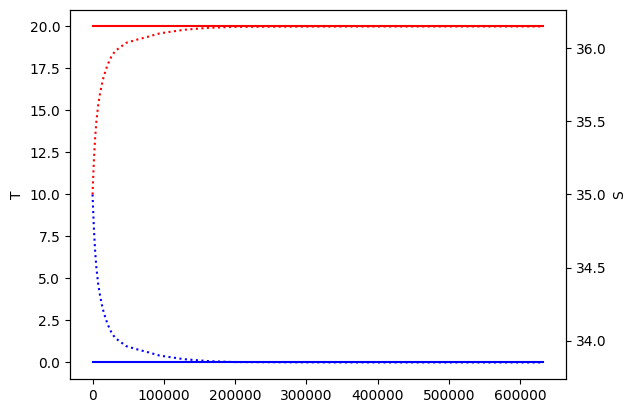

In [832]:
fig, ax = plt.subplots()

ax.plot(t, T1, 'b-')
ax.plot(t, T2, 'r-')
ax.set_ylabel('T')
ax2 = ax.twinx()
ax2.plot(t, S1, 'b:')
ax2.plot(t, S2, 'r:')
ax2.set_ylabel('S')

plt.show()

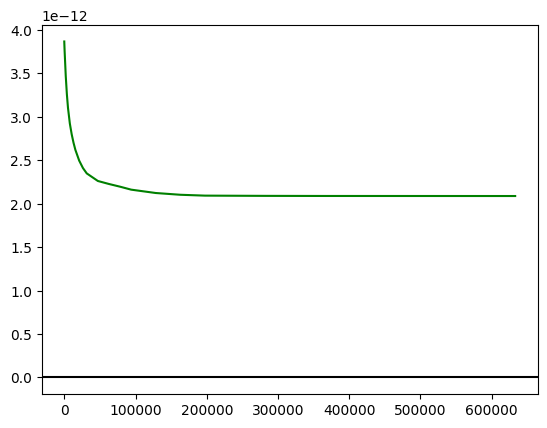

In [833]:
fig, ax = plt.subplots()

ax.plot(t, psi, 'g-')
ax.axhline(0, color='black')

# ax2 = ax.twinx()

# x2.plot(t, f_eta(t), 'g:')

plt.show()

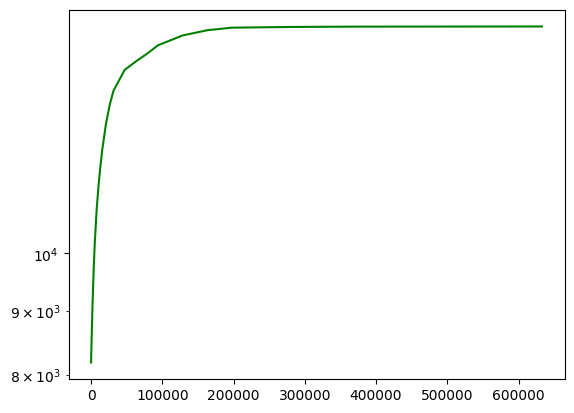

In [834]:
fig, ax = plt.subplots()

ax.plot(t, (1 / np.abs(psi)) / 3.16e7, 'g-')
ax.axhline(0, color='black')
ax.set_yscale('log')


plt.show()

In [835]:
def H(x, k=1e20):
    return 0.5 *((k*x) / (np.sqrt(1 + (k * x) ** 2)) + 1)

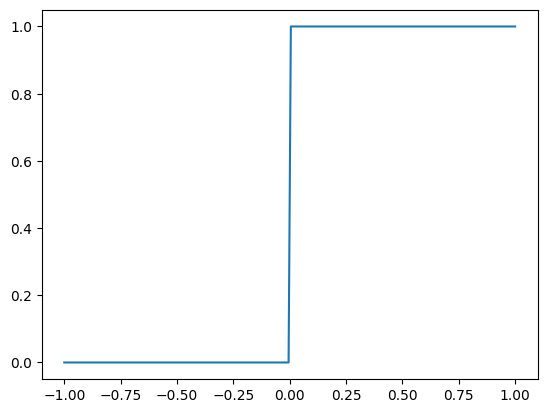

In [836]:
plt.plot(np.linspace(-1, 1, num=200), H(np.linspace(-1, 1, num=200)))

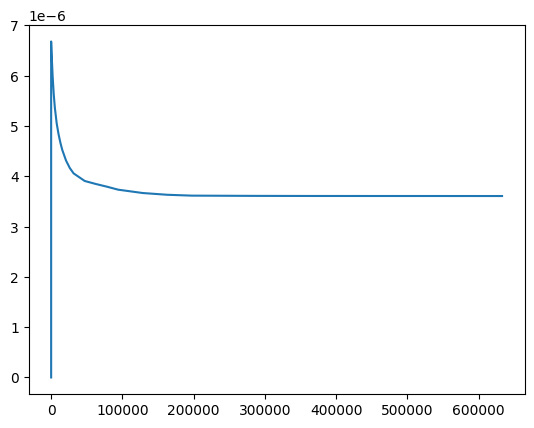

In [837]:
T_floor = H(psi) * T1 + H(-psi) * T2
plt.plot(t, T_floor)